In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import options as opt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Arithmetic Asian Option

In [26]:
#Antithetic technique : to improve accuracy
def asian_out_option_arithmetic(S0, K, n, T, r, vol, N, M):
    """
    S0 : price of the underlying at time t=0
    K : strike price of the option
    n : number of observations
    T : time to maturity
    r : risk-free rate
    vol : volatility
    N : number of timesteps
    M : number of simulations
    """
    #Pricing Asian (arithmetic) out option
    dt=T/N
    period=N//n
    nudt=(r-0.5*vol**2)*dt
    volsdt=vol*np.sqrt(dt)
    erdt=np.exp(-r*dt)

    sum_CT=0
    sum_CT2=0

    for i in range(M):
        St1=S0
        St2=S0
        At1_sum=0
        At2_sum=0
    
        for j in range (N):
            epsilon=np.random.normal()
            Stn1=St1*np.exp(nudt+volsdt*epsilon)
            Stn2=St2*np.exp(nudt-volsdt*epsilon)
            St1=Stn1
            St2=Stn2
            if (j + 1) % period == 0:
                At1_sum += St1
                At2_sum += St2
            
        A1=At1_sum/n
        A2=At2_sum/n
        CT=(np.maximum(A1-K, 0)+np.maximum(A2-K, 0))/2
        
        sum_CT+=CT
        sum_CT2+=CT**2
    
    C0=np.exp(-r*T)*sum_CT/M
    sigma=np.sqrt((sum_CT2-sum_CT*sum_CT/M)*np.exp(-2*r*T)/(M-1))
    SE=sigma/np.sqrt(M)    #Compute the standard error
    
    return C0

In [34]:
asian_out_option_arithmetic(100, 100, 12, 1, 0.02, 0.2, 100, 1000)

5.055743468017498

### Geometric Asian Option

In [55]:
def asian_out_geometric_option(S0, K, n, T, r, vol, N, M):
    """
    S0 : price of the underlying at time t=0
    K : strike price of the option
    n : number of observations
    T : time to maturity
    r : risk-free rate
    vol : volatility
    N : number of timesteps
    M : number of simulations
    """
    #Pricing Asian (geometric) out option
    dt=T/N
    period=N//n
    nudt=(r-0.5*vol**2)*dt
    volsdt=vol*np.sqrt(dt)
    erdt=np.exp(-r*dt)

    sum_CT=0
    sum_CT2=0

    for i in range(M):
        St1=S0
        St2=S0
        GT1=1
        GT2=1
    
        for j in range (N):
            epsilon=np.random.normal()
            Stn1=St1*np.exp(nudt+volsdt*epsilon)
            Stn2=St2*np.exp(nudt-volsdt*epsilon)
            St1=Stn1
            St2=Stn2
            if (j + 1) % period == 0:
                GT1*=St1
                GT2*=St2
            
        G1=GT1**(1/n)
        G2=GT2**(1/n)
        CT=(np.maximum(G1-K, 0)+np.maximum(G2-K, 0))/2
        
        sum_CT+=CT
        sum_CT2+=CT**2
    
    C0=np.exp(-r*T)*sum_CT/M
    sigma=np.sqrt((sum_CT2-sum_CT*sum_CT/M)*np.exp(-2*r*T)/(M-1))
    SE=sigma/np.sqrt(M)    #Compute the standard error
    
    return C0

In [56]:
asian_out_geometric_option(100, 100, 12, 1, 0.02, 0.2, 100, 1000)

5.089036016889826

### Hedge Asian Option

In [76]:
### Delta Hedge
def hedge_asian_option(S0, K, n, T, r, vol, N, M, position='long'):
    """
    S0 : price of the underlying at time t=0
    k : strike price
    n : number of observations
    T : time to maturity
    r : interest rate
    vol : volatility
    N : number of timesteps
    M : number of simulations
    position : should be 'long' or 'short'
    """
    dt=T/N
    period=N//n
    nudt=(r-0.5*vol**2)*dt
    volsdt=vol*np.sqrt(dt)
    erdt=np.exp(-r*dt)

    hedge_position_avg=np.zeros(N+1)
    cash_position_avg=np.zeros(N+1)
    PnL_avg = np.zeros(N + 1)
    time=np.linspace(0, T, N+1)

    for i in range (M):
        St=S0
        observations_count = 0
        avg_price_sum=0
        ITM = False

        hedge_position=np.zeros(N+1)
        cash_position=np.zeros(N+1)
        PnL = np.zeros(N + 1)

        delta_init=opt.delta_calc(r, S0, K, T, vol, type="c")

        hedge_position[0]=delta_init
        PnL[0] = hedge_position[0]*St

        for j in range (1, N+1):
            epsilon=np.random.normal()
            Stn=St*np.exp(nudt+volsdt*epsilon)
            St=Stn

            T_remaining = T - time[j]

            if St>K:
                ITM = True

            if j % period == 0:
                observations_count+=1
                avg_price_sum += St
                avg_price = avg_price_sum / observations_count
                weight=observations_count/n

                new_delta = opt.delta_calc(r, avg_price, K, T_remaining, vol, type="c")
                delta_change = new_delta-hedge_position[j-1]
            
                if ITM:
                    hedge_position[j]=weight*new_delta

                    cash_position[j]=cash_position[j-1]+weight*delta_change*St
                    PnL[j] = hedge_position[j]*St + cash_position[j]
                else:
                    hedge_position[j]=hedge_position[j-1]

                    cash_position[j]=cash_position[j-1]
                    PnL[j] = PnL[j-1]

            else:
                    hedge_position[j]=hedge_position[j-1]

                    cash_position[j]=cash_position[j-1]
                    PnL[j] = PnL[j-1]
        
        hedge_position_avg += hedge_position
        cash_position_avg += cash_position
        PnL_avg += PnL

    hedge_position_avg /= M
    cash_position_avg /= M
    PnL_avg /= M

    return hedge_position_avg, cash_position_avg, PnL_avg, time

In [77]:
hedge_position, cash_position, pnl, time = hedge_asian_option(100, 100, 12, 1, 0.02, 0.2, 100, 1000)

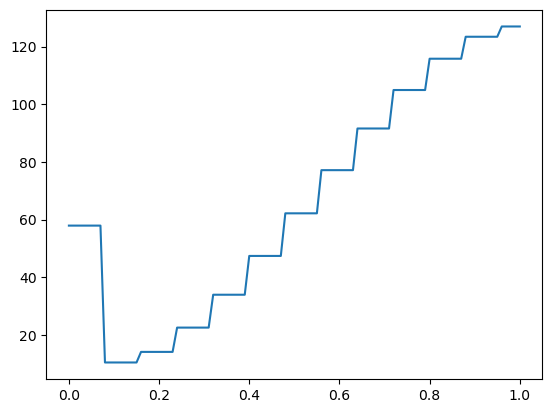

In [78]:
plt.plot(time, pnl)
plt.show()